In [1]:
import argparse
import numpy as np
import sys, os
import time
import h5py
import torch
import pandas as pd
# from src.retinafacetf2.retinaface import RetinaFace

codepath = '/user_data/mmhender/modfit/code'
sys.path.append(codepath)

#import custom modules
from utils import default_paths, nsd_utils
# from utils import coco_utils
from utils import segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 
import pandas as pd
from skimage import io
import copy
from matplotlib import pyplot as plt
import PIL

In [11]:
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    
dist = np.sum(np.abs(models-[-0.30,0.1,0.050]), axis=1)
# dist = np.sum(np.abs(models-[-0.30,0.1,0.50]), axis=1)
prf_ind = np.argmin(dist)
prf_ind

367

In [3]:
save_labels_path = os.path.join(default_paths.stim_labels_root, 'face_labels_retinaface')
subject=1
fn2load1 = os.path.join(save_labels_path, 'S%d_facelabels.npy'%(subject))  
f = np.load(fn2load1, allow_pickle=True).item()

fn2load2 = os.path.join(default_paths.stim_labels_root, 'S%d_face_binary.csv'%(subject))
fn2load3 = os.path.join(default_paths.stim_labels_root, \
                        'S%d_within_prf_grid%d'%(subject,which_prf_grid), \
                        'S%d_face_binary_prf%d.csv'%(subject,prf_ind))

df = pd.read_csv(fn2load3, index_col=0)
has_face = np.array(df)


In [4]:
f['n_faces_each'][6467]

1.0

In [5]:
has_face[6467]

array([False])

In [6]:
image_data = nsd_utils.get_image_data(subject)  


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [12]:
# Get masks for every pRF (circular), in coords of NSD images
n_prfs = len(models)
n_pix = 240
n_prf_sd_out = 2
prf_masks = np.zeros((n_prfs, n_pix, n_pix))

for mm in range(n_prfs):    
    prf_params = models[mm,:] 
    x,y,sigma = prf_params
    aperture=1.0
    prf_mask = prf_utils.get_prf_mask(center=[x,y], sd=sigma, \
                           patch_size=n_pix)
    prf_masks[prf_ind,:,:] = prf_mask.astype('int')

In [13]:
prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
n_pix = 240
aperture=1.0
prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                      dtype=np.float32)
prf_mask = prf_utils.get_prf_mask(center=[x, y], sd=sigma, patch_size=n_pix)
mask_sum = np.sum(prf_mask)
min_pix_req = np.ceil(mask_sum*0.10)

n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

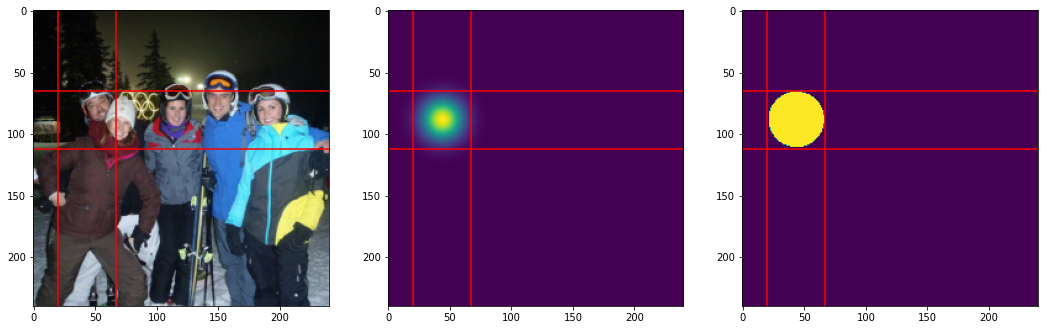

In [14]:
# Plot pRF bounding boxes

ii = np.where(has_face)[0][0]
nsd_image = np.moveaxis(image_data[ii,:,:,:], [0],[2])

plt.figure(figsize=(18,6));
plt.subplot(1,3,1)
plt.imshow(nsd_image)
# show the prf on top to make sure it is where it should be
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,2)
plt.imshow(prf)
# plt.colorbar()
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(1,3,3)
plt.imshow(prf_mask)
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

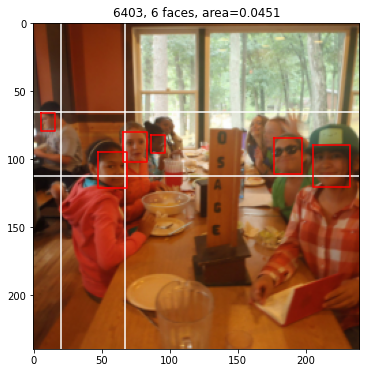

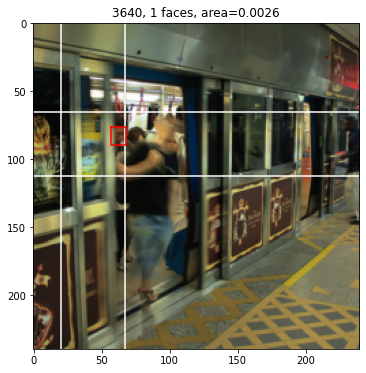

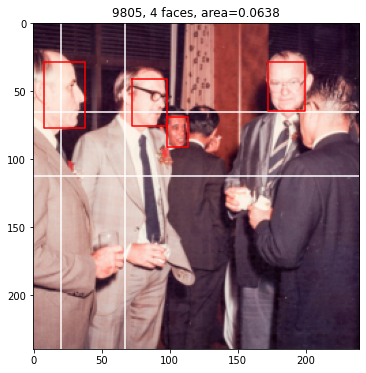

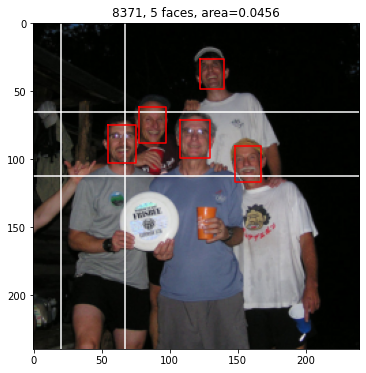

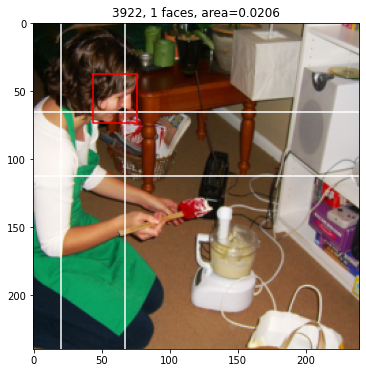

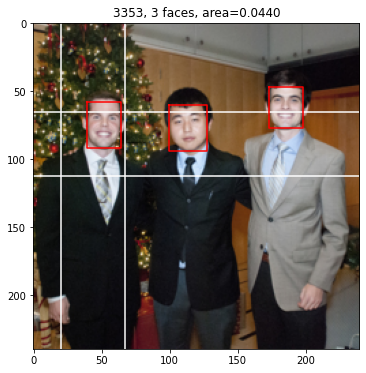

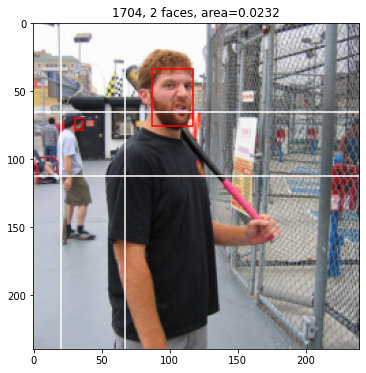

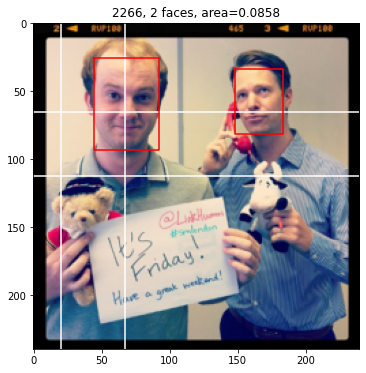

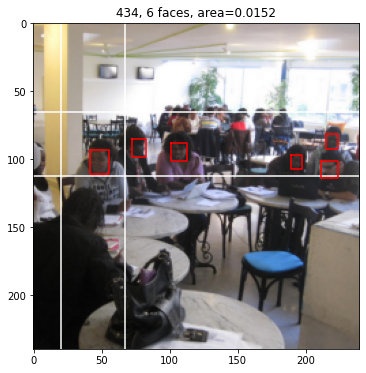

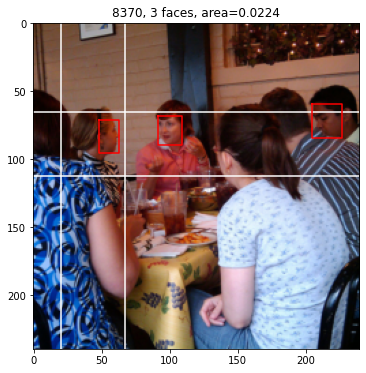

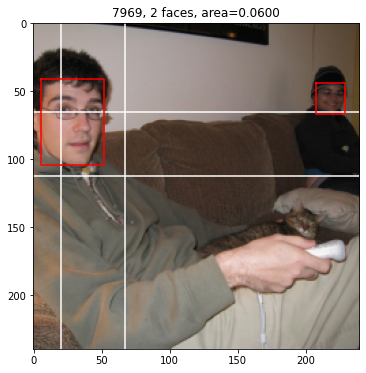

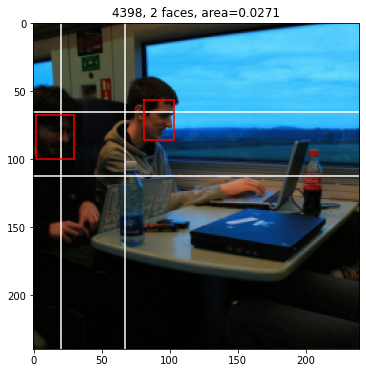

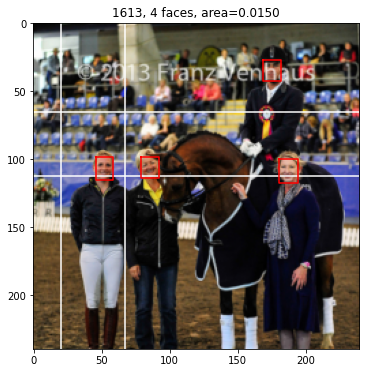

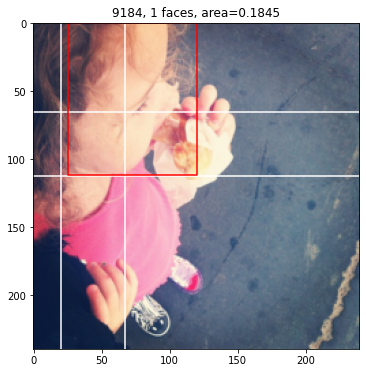

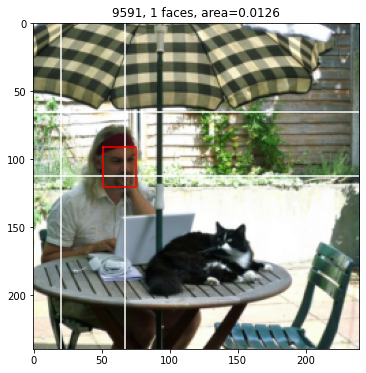

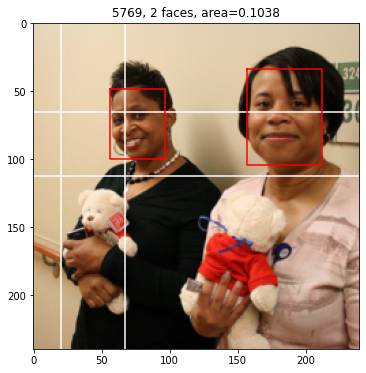

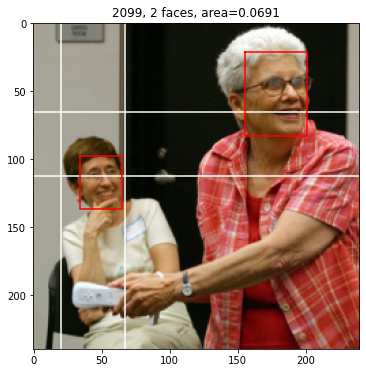

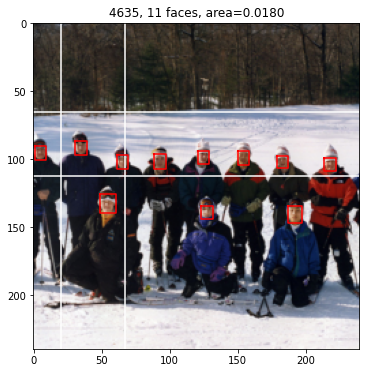

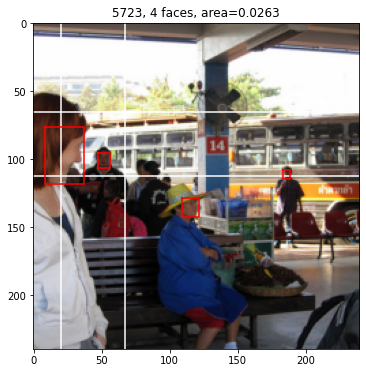

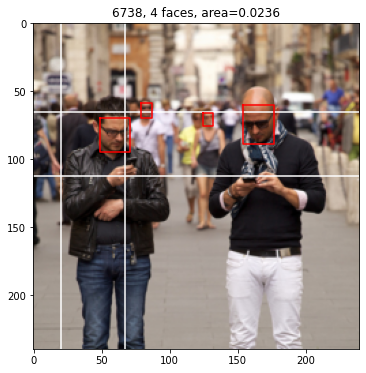

In [15]:
for ii in np.random.choice(np.where(has_face)[0], 20, replace=False):

    imdat = np.moveaxis(image_data[ii,:,:,:], [0],[2])

    plt.figure(figsize=(6,6))
    plt.imshow(imdat)
    
    plt.axhline([prf_bbox[0]],color='w')
    plt.axhline([prf_bbox[1]],color='w')
    plt.axvline([prf_bbox[2]],color='w')
    plt.axvline([prf_bbox[3]],color='w')

    face_boxes = f['faces'][ii]
    n_faces = face_boxes.shape[0]

    face_area=0;
    # for nn in [0]:
    for nn in range(n_faces):

        box = face_boxes[nn,:]
        x1,y1,x2,y2,_ = box
        xcoords = [x1,x1,x2,x2,x1]
        ycoords = [y1,y2,y2,y1,y1]
        
        face_area += ((x2-x1)*(y2-y1))/(240*240)

        plt.plot(xcoords, ycoords,color='r')
        
    plt.title('%d, %d faces, area=%.4f'%(ii, n_faces, face_area))

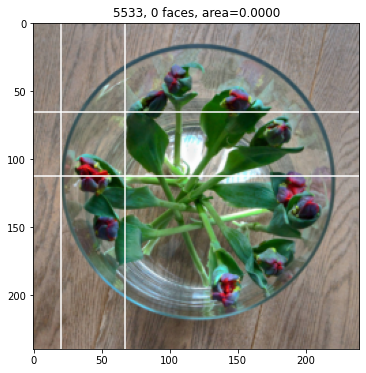

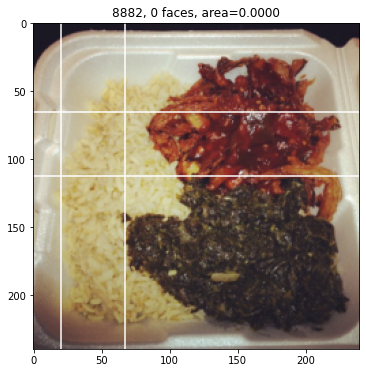

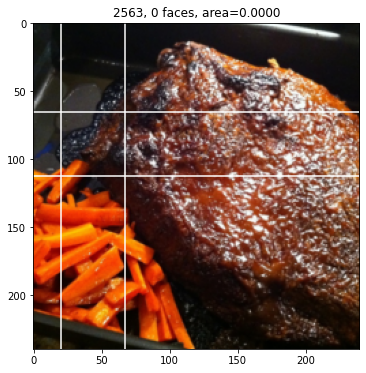

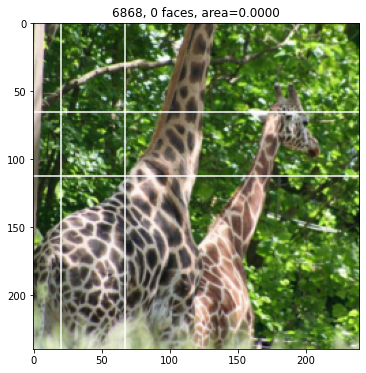

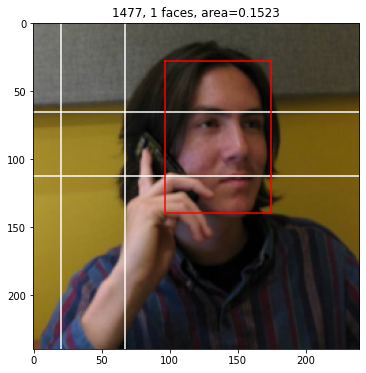

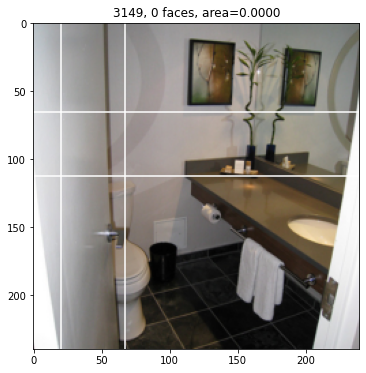

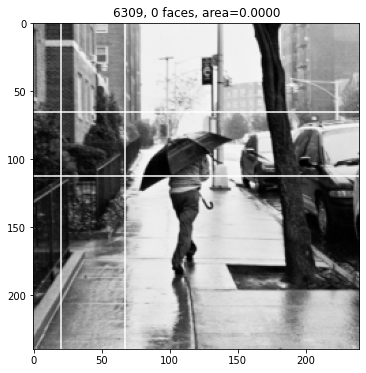

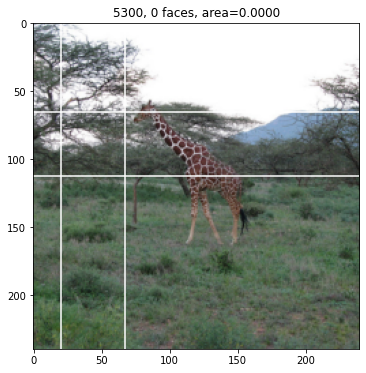

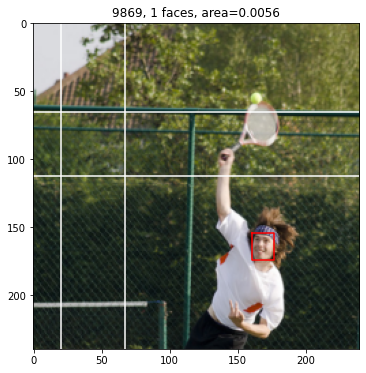

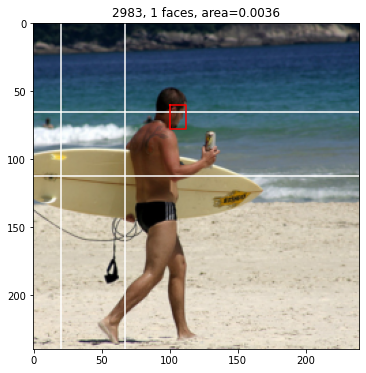

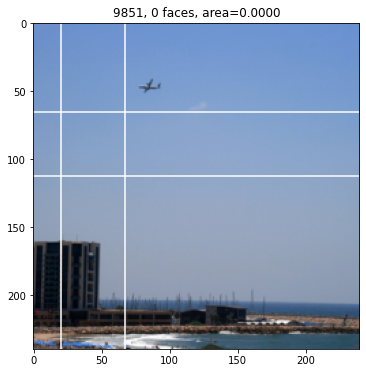

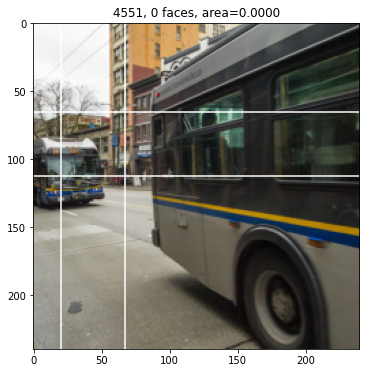

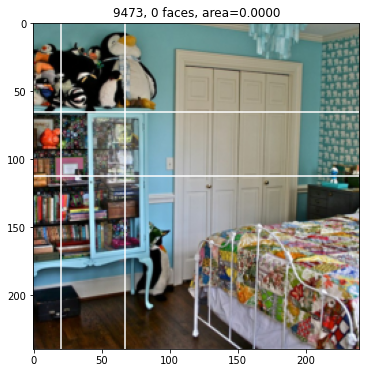

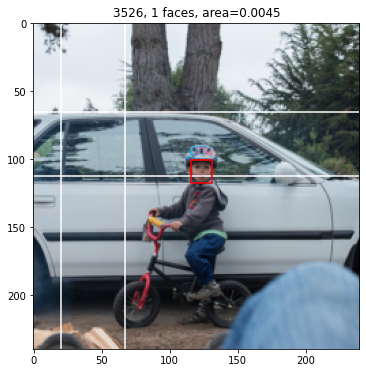

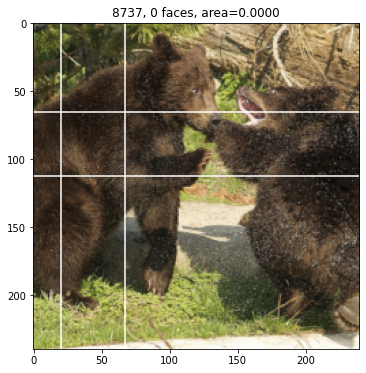

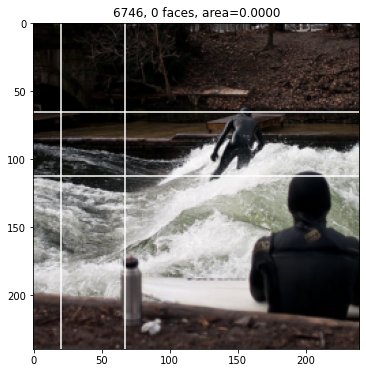

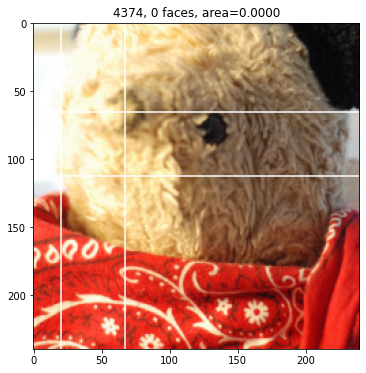

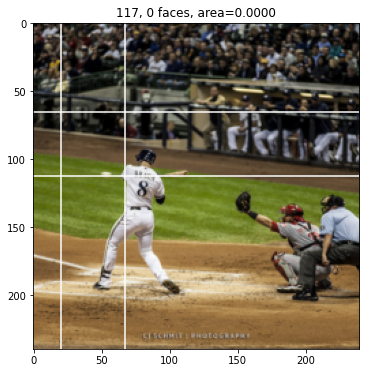

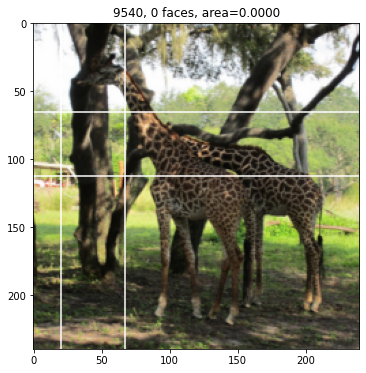

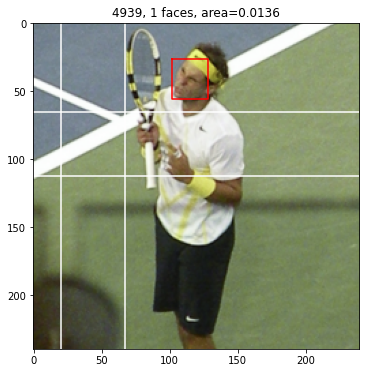

In [16]:
for ii in np.random.choice(np.where(~has_face)[0], 20, replace=False):

    imdat = np.moveaxis(image_data[ii,:,:,:], [0],[2])

    plt.figure(figsize=(6,6))
    plt.imshow(imdat)
    
    plt.axhline([prf_bbox[0]],color='w')
    plt.axhline([prf_bbox[1]],color='w')
    plt.axvline([prf_bbox[2]],color='w')
    plt.axvline([prf_bbox[3]],color='w')

    face_boxes = f['faces'][ii]
    n_faces = face_boxes.shape[0]

    face_area=0;
    # for nn in [0]:
    for nn in range(n_faces):

        box = face_boxes[nn,:]
        x1,y1,x2,y2,_ = box
        xcoords = [x1,x1,x2,x2,x1]
        ycoords = [y1,y2,y2,y1,y1]
        
        face_area += ((x2-x1)*(y2-y1))/(240*240)

        plt.plot(xcoords, ycoords,color='r')
        
    plt.title('%d, %d faces, area=%.4f'%(ii, n_faces, face_area))